In [2]:
#import library
import time
import rioxarray
import xarray as xr 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

#### Data Preparation

In [65]:
#open dataset
label_path = r"D:\Project\Land Use Classification\Raster\label_ds.tif"
raster_path = r"D:\Project\Land Use Classification\Raster\rio_sentinel_medan.tif"

label_ds = rioxarray.open_rasterio(label_path)
raster_ds = rioxarray.open_rasterio(raster_path)

In [66]:
#align label dataset before merging with raster dataset
label_ds = label_ds.rio.reproject_match(
    raster_ds,
    Resampling = "nearest"
)

#handle nodata
print(label_ds.rio.nodata)
print(raster_ds.rio.nodata)

label_ds = label_ds.where(label_ds != -128)
raster_ds = raster_ds.where(raster_ds != -3.4028235e+38)

# update metadata nodata
label_ds = label_ds.rio.write_nodata(np.nan)
raster_ds = raster_ds.rio.write_nodata(np.nan)

-128
-3.4028235e+38


In [ ]:
#marge dataset
sentinel_terrain = raster_ds.to_dataset(dim = 'band')
label_ds = label_ds.to_dataset(name='class')

dataset = xr.merge([sentinel_terrain, label_ds])
dataset

In [26]:
#convert the data to a dataframe
df_dataset = (
    dataset
    .to_dataframe()
    .reset_index()
    .drop(columns=['spatial_ref', 'band'])
    .set_index(['y', 'x'])
    .dropna(how='all')
)

In [27]:
#change name band 
band_list = ['Blue', 'Green', 'Red', 'Red Edge 1', 'Red Edge 2', 'Red Edge 3', 'NIR', 'Red Edge 4', 'SWIR1', 'SWIR2', 'DEM_Elevation', 'DEM_Slope', 'DEM_TWI', 'Class']
df_dataset.columns = band_list

#### Prepare training and testing dataset using sentinel and terrain dataset

In [28]:
df_model = df_dataset.dropna()
df_model

Blue   Green     Red  Red Edge 1  Red Edge 2  \
y         x                                                          
9188030.0 423010.0  0.0251  0.0424  0.0198      0.0669      0.2509   
          423030.0  0.0254  0.0423  0.0212      0.0696      0.2643   
          423050.0  0.0249  0.0439  0.0206      0.0704      0.2726   
          423070.0  0.0234  0.0409  0.0216      0.0696      0.2706   
          423130.0  0.0245  0.0428  0.0210      0.0665      0.2452   
...                    ...     ...     ...         ...         ...   
9157550.0 441910.0  0.0233  0.0388  0.0233      0.0705      0.2532   
          441930.0  0.0256  0.0417  0.0271      0.0686      0.2596   
          441950.0  0.0233  0.0431  0.0275      0.0741      0.2327   
          441970.0  0.0192  0.0349  0.0191      0.0663      0.2652   
          441990.0  0.0459  0.0622  0.0533      0.0900      0.2376   

                    Red Edge 3     NIR  Red Edge 4   SWIR1   SWIR2  \
y         x                                                          
9188030.0 423010.0      0.2933  0.3016      0.3204  0.1434  0.0610   
          423030.0      0.3197  0.3228      0.3427  0.1504  0.0649   
          423050.0      0.3277  0.3360      0.3561  0.1548  0.0669   
          423070.0      0.3291  0.3310      0.3587  0.1557  0.0650   
          423130.0      0.3043  0.3205      0.3153  0.1450  0.0570   
...                        ...     ...         ...     ...     ...   
9157550.0 441910.0      0.2951  0.2866      0.3444  0.1639  0.0739   
          441930.0      0.3160  0.2970      0.3338  0.1698  0.0881   
          441950.0      0.3115  0.3119      0.3524  0.1769  0.0868   
          441970.0      0.3212  0.3244      0.3448  0.1665  0.0810   
          441990.0      0.3069  0.2840      0.3177  0.1889  0.1137   

                    DEM_Elevation  DEM_Slope   DEM_TWI  Class  
y         x                                                    
9188030.0 423010.0       0.196016   0.079589  0.147046    8.0  
          423030.0       0.196016   0.096651  0.157356    8.0  
          423050.0       0.196802   0.125198  0.102216    8.0  
          423070.0       0.196571   0.141205  0.156830    8.0  
          423130.0       0.196924   0.212198  0.082643    8.0  
...                           ...        ...       ...    ...  
9157550.0 441910.0       0.217148   0.036756  0.157604    8.0  
          441930.0       0.216644   0.025855  0.177435    8.0  
          441950.0       0.216644   0.054489  0.140196    8.0  
          441970.0       0.215421   0.100966  0.310752    8.0  
          441990.0       0.214716   0.061356  0.340596    8.0  

[125696 rows x 14 columns]

In [29]:
X = df_model[['Blue', 'Green', 'Red', 'Red Edge 1', 'Red Edge 2', 'Red Edge 3', 'NIR', 'Red Edge 4', 'SWIR1', 'SWIR2', 'DEM_Elevation', 'DEM_Slope', 'DEM_TWI']]
y = df_model['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size= 0.3,
    stratify= y,
    random_state= 42
)

#### Hyperparameter Tuning

In [50]:
#Create Function to Hyperparameter Tuning
def tuning_model(classifier, X_train, y_train, save_csv_path="tuning_result_sim_rf_1des.csv"):
    p_list = np.array([1, 2, 3, 4, 5])     # max_features
    n_list = np.array([100, 200, 300, 400, 500])   # n_estimators

    tuning_results = []
    best_score = -1
    best_params = {}

    for p in p_list:
        for n in n_list:
            start_time = time.time()

            classifier.set_params(max_features=p, n_estimators=n)
            cv_allscores = cross_val_score(classifier, X_train, y_train,
                                           scoring='accuracy', cv=5)
            end_time = time.time()
            elapsed_time = (end_time - start_time)/60
            cv_avgscore = cv_allscores.mean()

            tuning_results.append({
                "max_features": p,
                "n_estimators": n,
                "mean_accuracy": cv_avgscore,
                "all_scores": cv_allscores.tolist(),
                "elapsed_time_sec": round(elapsed_time, 2)
            })

            if cv_avgscore > best_score:
                best_score = cv_avgscore
                best_params = {"max_features": p, "n_estimators": n}

            print(f"max_features={p}, n_estimators={n}, "
                  f"acc={cv_avgscore:.4f}, time={elapsed_time:.2f}m")

    # Simpan hasil ke CSV
    df_result = pd.DataFrame(tuning_results)
    df_result.to_csv(save_csv_path, index=False)
    print(f"The tuning results are saved to: {save_csv_path}")
    print("Best Parameters:", best_params)
    print("Best CV Score:", best_score)

    return best_params, best_score, df_result

In [ ]:
#apply the hyperparameter tuning
rf = RandomForestClassifier(oob_score=True, random_state=42)
tuning_model(rf, X_train, y_train);

#### Apply Random Forest Classification

In [30]:
def final_model(classifier, X_train, X_test, y_train, y_test):
    # === Training ===
    classifier.fit(X_train, y_train)
    # === Prediction ===
    y_train_pred = classifier.predict(X_train)
    y_test_pred  = classifier.predict(X_test)
    # === Accuracy ===
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test  = accuracy_score(y_test, y_test_pred)

    print(f'Training Accuracy = {acc_train:.2f}')
    print(f'Testing Accuracy  = {acc_test:.2f}')
    # === Classification Report ===
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_test_pred)
    labels = sorted(set(y_test))
    print("\nConfusion Matrix (Test Data):")
    print(cm)

    # === Visualisasi Confusion Matrix ===
    plt.figure(figsize=(14, 12))  # ukuran figure lebih besar
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 6},   # ukuran angka di dalam kotak
        cbar_kws={"shrink": 0.8} # ukuran colorbar lebih ramping
    )
    plt.xlabel("Predicted Label", fontsize=10)
    plt.ylabel("True Label", fontsize=10)
    plt.title("Confusion Matrix", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

    # === Feature Importance ===
    if hasattr(classifier, "feature_importances_"):
        print('\nPredictor importance:')
        for predictor, importance in zip(list(X_train), classifier.feature_importances_):
            print(f'    {predictor:6s}: {importance:.2%}')

    return y_train_pred, y_test_pred

Training Accuracy = 1.00
Testing Accuracy  = 0.93

Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97      3497
         2.0       0.87      0.70      0.78      1068
         3.0       0.92      0.95      0.93      5375
         4.0       0.99      0.95      0.97      2476
         5.0       0.91      0.96      0.93      8482
         7.0       0.94      0.96      0.95      1538
         8.0       0.91      0.90      0.90      4407
        10.0       0.96      0.93      0.94      2033
        11.0       0.97      0.97      0.97      1523
        12.0       0.93      0.88      0.90       224
        13.0       0.94      0.92      0.93      2092
        14.0       0.90      0.88      0.89      4749
        15.0       0.98      0.96      0.97       178
        16.0       1.00      0.73      0.84        67

    accuracy                           0.93     37709
   macro avg       0.94      0.90      0.92     

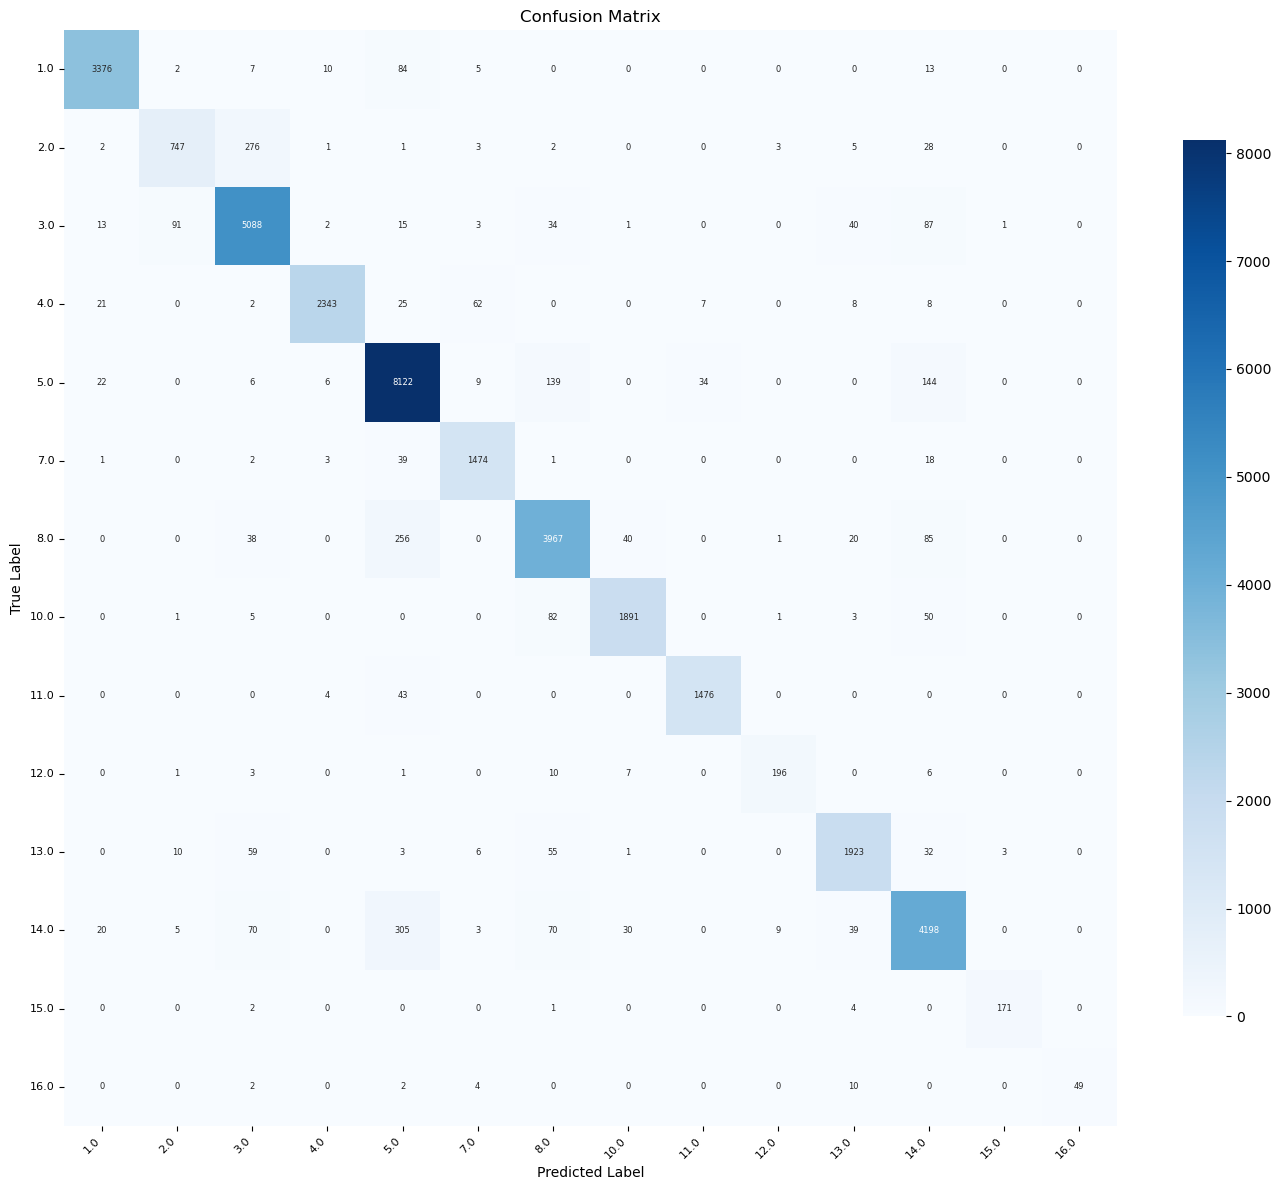


Predictor importance:
    Blue  : 7.88%
    Green : 5.71%
    Red   : 9.23%
    Red Edge 1: 6.42%
    Red Edge 2: 4.33%
    Red Edge 3: 5.88%
    NIR   : 4.25%
    Red Edge 4: 7.10%
    SWIR1 : 8.17%
    SWIR2 : 8.75%
    DEM_Elevation: 21.83%
    DEM_Slope: 8.67%
    DEM_TWI: 1.79%


In [31]:
class_rf = RandomForestClassifier(n_estimators=500,
                                max_features=4,
                                oob_score=True,
                                random_state=42)

rf_y_train_pred, rf_y_test_pred = final_model(class_rf, X_train, X_test, y_train, y_test)

#### Inference model

In [68]:
df_inference = df_dataset.drop(columns=['Class'])

df_inference['land_use'] = class_rf.predict(df_inference)

#### Visualization

In [69]:
data_inference = df_inference.to_xarray().sortby('x').sortby('y')

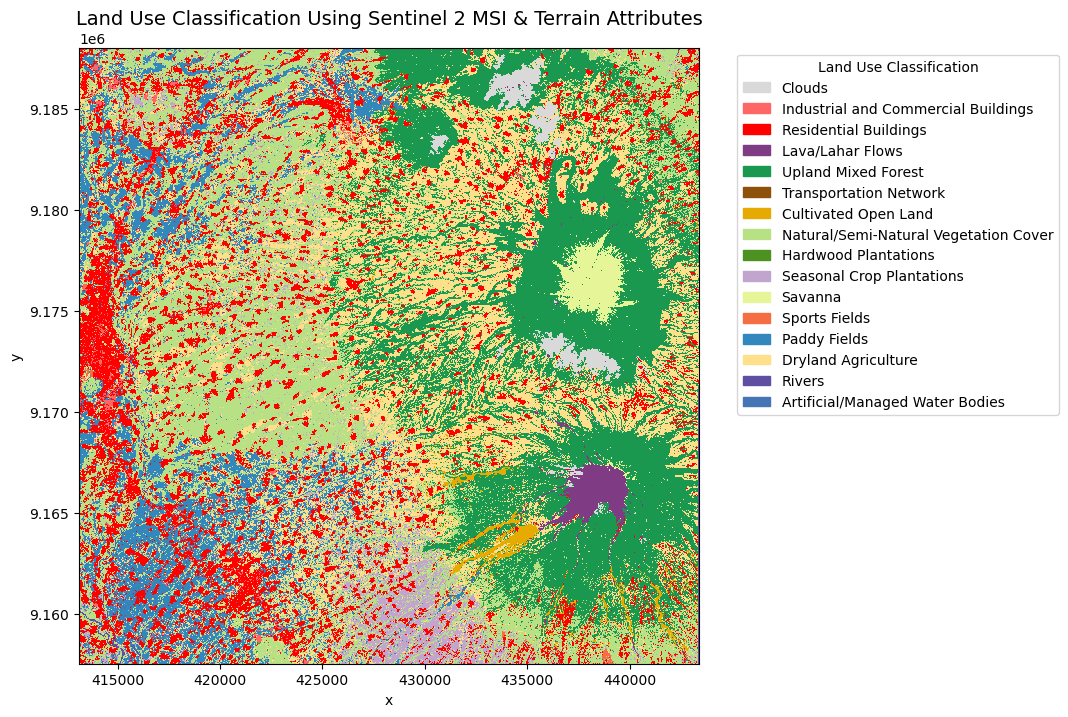

In [ ]:
# Class definitions (in table order)
classes = list(range(1, 16))
labels = [
    'Clouds',
    'Industrial and Commercial Buildings',
    'Residential Buildings',
    'Lava/Lahar Flows',
    'Upland Mixed Forest',
    'Transportation Network',
    'Cultivated Open Land',
    'Natural/Semi-Natural Vegetation Cover',
    'Hardwood Plantations',
    'Seasonal Crop Plantations',
    'Savanna',
    'Sports Fields',
    'Paddy Fields',
    'Dryland Agriculture',
    'Rivers',
    'Artificial/Managed Water Bodies'
]

# Create color for each land use classification
colors = [
    "#d9d9d9",  
    "#ff6666",  
    "#ff0000", 
    "#7f3b83",  
    "#1a9850",  
    "#8c510a", 
    "#e6ab02", 
    "#b8e186", 
    "#4d9221", 
    "#c2a5cf", 
    "#e6f598", 
    "#f46d43", 
    "#3288bd",  
    "#fee08b",  
    "#5e4fa2",  
    "#4575b4"   
]

# Create colormap
cmap = mcolors.ListedColormap(colors)

# Plot klasifikasi
fig, ax = plt.subplots(figsize=(8, 8))
im = data_inference.land_use.plot(
    ax=ax,
    x="x",
    y="y",
    cmap=cmap,
    add_colorbar=False
)

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
ax.legend(handles, labels, title="Land Use Classification",
          bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_title("Land Use Classification Using Sentinel 2 MSI & Terrain Attributes", fontsize=14)

output_path = "Land Use Classification Using Sentinel 2 MSI-tes.png"
plt.savefig(
    output_path,
    dpi=400,          
    bbox_inches='tight',
    pad_inches=0.1,     
    transparent=False   
)
plt.show()

#### Save to Geotif

In [ ]:
ds_save = data_inference['land_use']
save_data = ds_save.rio.write_crs('EPSG:32749')
save_data.rio.to_raster('land_use_sentinel_terrain_rf.tif')